In [4]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares,leastsq
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
#from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
#import riip
import matplotlib.colors as colors
import matplotlib.patches as patches

In [5]:
cal_file1 = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pixel_registration\\cam1pixel.h5'
cal_file2 = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pixel_registration\\cam2pixel.h5'

In [6]:
t_hor = 5010;
lambda_min = 7;
lambda_max = 13;
waves = np.linspace(7,12,120)
A_ne = 4.0832;
B_ne = 2.0041;
C_ne = .20646;
D_ne = 3.9928;
E_ne = 3866.92;
A_no = 4.1318;
B_no = 1.8584;
C_no = .21999;
D_no = 2.76773;
E_no = 2962.98;
def retardance(wavelength):
    ne = np.sqrt(A_ne + (B_ne*wavelength**2)/(wavelength**2 - C_ne) + (D_ne*wavelength**2)/(wavelength**2 - E_ne));
    no = np.sqrt(A_no + (B_no*wavelength**2)/(wavelength**2 - C_no) + (D_no*wavelength**2)/(wavelength**2 - E_no)); 
    b = ne - no; 

    retardance = (b*t_hor);
    return retardance

In [7]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

In [8]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

In [12]:
poldata = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pol_compare\\23C\\150BB\\'
angles = np.arange(0,360,1)
numangles = len(angles)
img1 = np.zeros([numangles,256,320])
img2 = np.zeros([numangles,256,320])
std1 = np.zeros([numangles,256,320])
std2 = np.zeros([numangles,256,320])
t1 = np.zeros(numangles)
t2 = np.zeros(numangles)

for i in range(numangles):
    with h5py.File(poldata + str(angles[i])+'deg.h5', "r") as f:
        img1[i] = np.mean(np.array(f[list(f.keys())[0]]),axis = 0) #cam 1 is reflection camera
        t1[i] = np.array(f[list(f.keys())[4]])
        std1[i] = np.array(f[list(f.keys())[2]])
        img2[i] = np.mean(np.array(f[list(f.keys())[1]]),axis = 0) #cam 2 is transmission camera
        t2[i] = np.array(f[list(f.keys())[5]])
        std2[i] = np.array(f[list(f.keys())[3]])


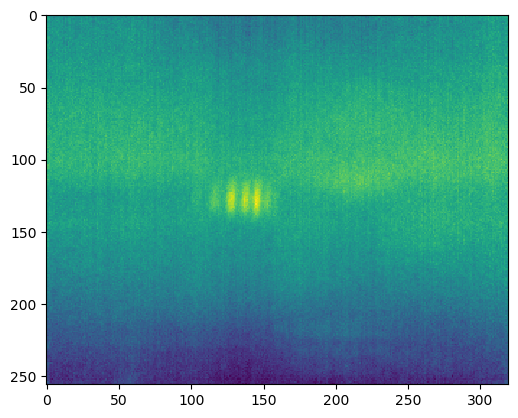

In [13]:
plt.style.use('default')
plt.imshow(img2[90])

In [14]:
xmin1 = 105; xmax1 = 170; #active region
ymin1 = 95; ymax1 = 138;
xmin2 = 105; xmax2 = 165;
ymin2 = 110; ymax2 = 150;

FOV = 5.33
HFOV = FOV/4

In [15]:
im1 = []
im2 = []
for t in range(numangles):
    
   # c1 = (img1[t] - np.mean(img1[t][160:170,145:155]))    
   # c2 = (img2[t] - np.mean(img2[t][160:170,145:155]))    
    
    
    c1 = (img1[t] - np.mean(img1[t][160:210,145:155]))    
    c2 = (img2[t] - np.mean(img2[t][200:256,145:155]))
    
    
    
   # c1 = (img1[t] - np.mean(img1[t][160:200,140:150]))    #3C
  #  c2 = (img2[t] - np.mean(img2[t][0:50,145:155]))    
    
   # c1 = (img1[t] - np.mean(img1[t][160:170,145:155]))    #13C
   # c2 = (img2[t] - np.mean(img2[t][200:256,0:50]))    
    
    
    
    im1.append(c1)
    im2.append(c2)

In [16]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [17]:
p1 = pixel_registration(im1[0],cal_file1,waves,0,320)
p2 = pixel_registration(im2[0],cal_file2,waves,0,320)
#plt.plot(np.sum(p1,axis = 1))
#plt.show()
#plt.plot(np.sum(p2,axis = 1))
#plt.show()
#y2 = np.argmax(np.sum(p2,axis = 1))
#y1 = np.argmax(np.sum(p1,axis = 1))
y2 = 129
y1 = 118


In [18]:
responses = np.zeros([len(angles),len(waves)])
responses1 = np.zeros([len(angles),len(waves)])
responses2 = np.zeros([len(angles),len(waves)])
responses_err = np.zeros([len(angles),len(waves)])
responses_err1 = np.zeros([len(angles),len(waves)])
responses_err2 = np.zeros([len(angles),len(waves)])

for a in range(len(angles)):
    p2 = pixel_registration(im2[a],cal_file2,waves,ymin2,ymax2)
    p1 = pixel_registration(im1[a],cal_file1,waves,ymin1,ymax1)
    s2 = pixel_registration(std2[a],cal_file2,waves,ymin2,ymax2)
    s1 = pixel_registration(std1[a],cal_file1,waves,ymin1,ymax1)

    err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
    responses[a]= (p1[y1-ymin1]+p2[y2-ymin2])
    responses_err[a]= err
    
    responses1[a]= p1[y1-ymin1]
    responses_err1[a]= s1[y1-ymin1]
    responses2[a]= p2[y2-ymin2]
    responses_err2[a]= s2[y2-ymin2]

In [19]:
def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2)
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return(T)

In [20]:
R1 = responses1
R2 = responses2
E1 = responses_err1
E2 = responses_err2

In [21]:
t_unpol = np.mean(R1,axis = 0)/np.mean(R2,axis = 0)

transmission_aolp = np.zeros([len(angles),len(pixel_c)])
for a in range(len(angles)):
    I1 = R1[a]
    I2 = R2[a]
    for i in range(len(pixel_c)):
        v = transmission_correction(I1[pixel1[i]:pixel2[i]],I2[pixel1[i]:pixel2[i]],3)
        transmission_aolp[a,i] = v

In [22]:
np.shape(transmission_aolp)

(360, 113)

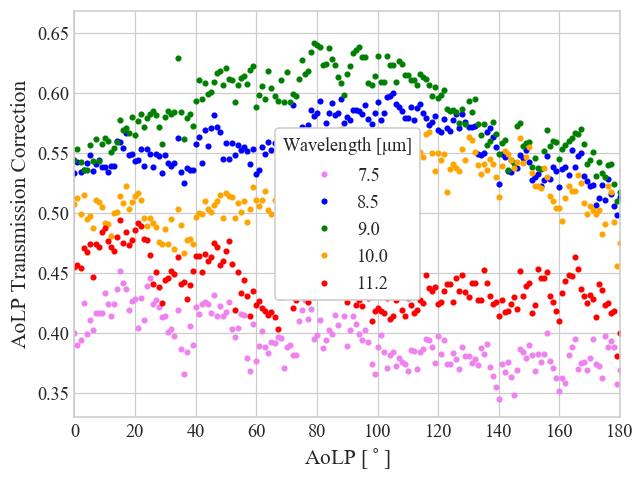

In [23]:
plt.style.use('seaborn-whitegrid')

textwidth = 5.9

#Plotting Options
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

fig = fig = plt.gcf() 
plt.plot(angles,transmission_aolp[:,4],'.',color = 'violet',label = str(round(lambda_c[4],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,28],'.',color = 'blue',label = str(round(lambda_c[28],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,40],'.',color = 'green',label = str(round(lambda_c[40],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,64],'.',color = 'orange',label = str(round(lambda_c[64],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,94],'.',color = 'red',label = str(round(lambda_c[94],1)),alpha = 1)

plt.ylabel("AoLP Transmission Correction",fontsize = 14)
plt.xlabel('AoLP [$^\circ$]')

plt.xlim(0,180)
plt.gcf().set_dpi(110)

legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')

In [24]:
#error propagation
def mod_uncertainty(x,y,sigma_x,sigma_y):
    dm_mI = (4*x**2)/(x+y)**4
    return (dm_mI*(sigma_x**2 + sigma_y**2))**0.5

In [25]:
#calculate modulation function for calibration data
calibration_mod = np.zeros([len(angles),len(pixel_c)])
calibration_I1  = np.zeros([len(angles),len(pixel_c)])
calibration_I2  = np.zeros([len(angles),len(pixel_c)])
calibration_modE  = np.zeros([len(angles),len(pixel_c)])

for a in range(len(angles)):
    I1 = R1[a,pixel_c[0]:pixel_c[-1]+1]#/t_unpol[pixel_c[0]:pixel_c[-1]+1]
    I2 = R2[a,pixel_c[0]:pixel_c[-1]+1]#*transmission_aolp[a]
    e1 = E1[a,pixel_c[0]:pixel_c[-1]+1]
    e2 = E2[a,pixel_c[0]:pixel_c[-1]+1]

    mod_a = (I1-I2)/(I1+I2)
    mod_e = mod_uncertainty(I1,I2,e1,e2)
                            
    calibration_I1[a]  = I1
    calibration_I2[a]  = I2
    calibration_mod[a] = mod_a
    calibration_modE[a] = mod_e

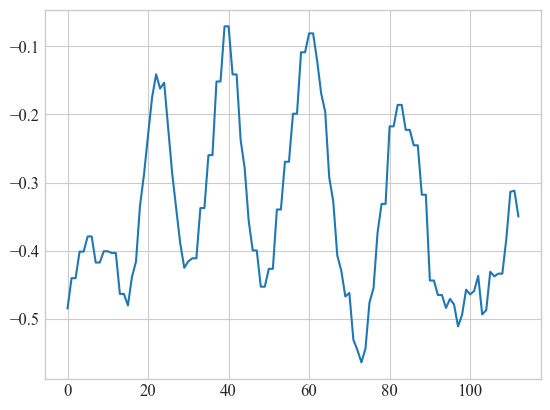

In [26]:
plt.plot(mod_a)

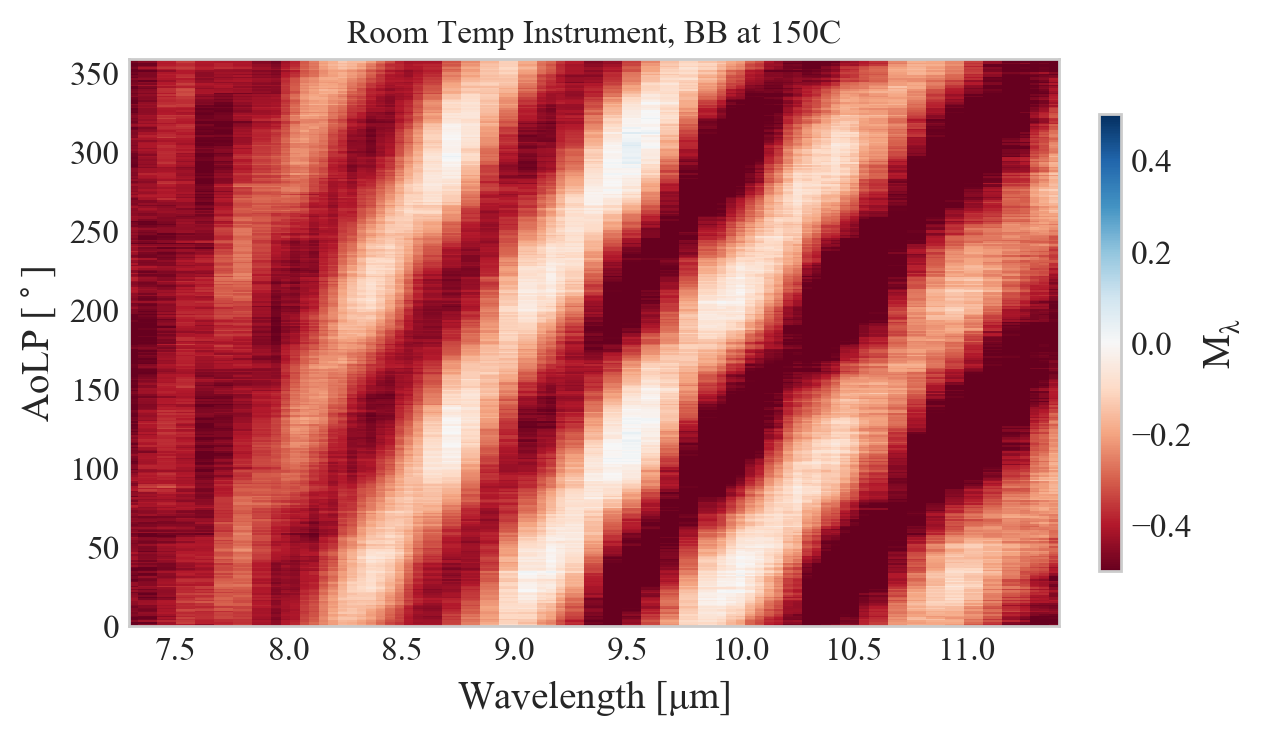

In [27]:
fig =plt.gcf()
plt.gca().set_aspect(.007)
plt.pcolormesh(lambda_c[:99],angles,calibration_mod[:,:99],shading='auto',norm=colors.PowerNorm(gamma=1,vmin = -.5,vmax = .5),cmap = 'RdBu')
plt.colorbar(label = "$\mathdefault{M_\lambda}$",fraction=0.023, pad=0.04)
plt.gcf().set_dpi(200)
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('AoLP [$^\circ$]')

plt.title("Room Temp Instrument, BB at 150C")
plt.show()

In [28]:
from astropy.timeseries import LombScargle

In [29]:
wav=list(map(lambda l :1/(l*1.0e-4),lambda_c))
wavnums=list(map(lambda l :1/(l*1.0e-4),waves))
ret=list(map(lambda l :(retardance(l)/l)*1.0e-3,lambda_c))

8.134453781512605
expected retardance 0.011446112708018584
0.011122255528902027


C:\Users\khart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\khart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


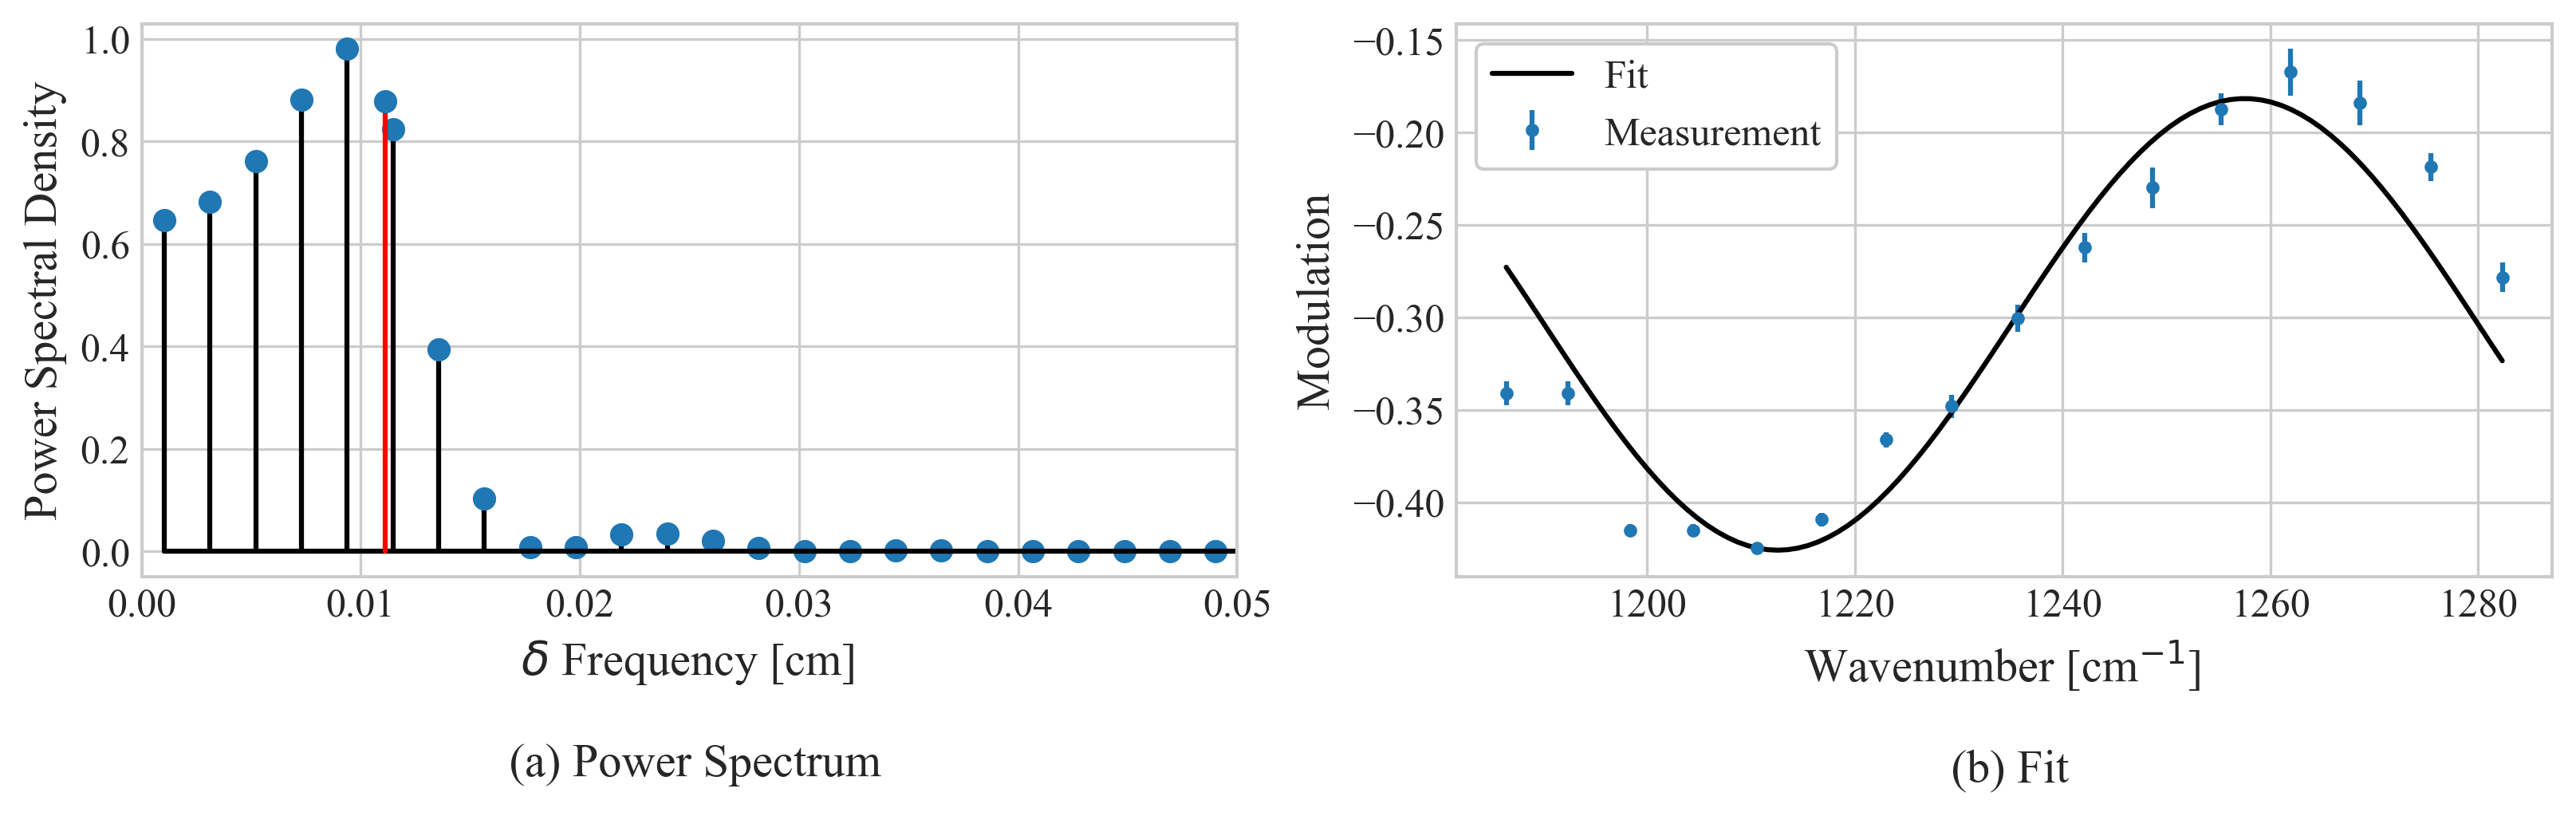

In [30]:
a = 0
j = 20
print(lambda_c[j])
print('expected retardance ' + str(ret[j]))
start = pixel1[j] #first pixel 
stop  = pixel2[j] #last pixel 
n = stop-start;

x = wavnums[start:stop] #select mod period
data = calibration_mod[a] 
data_err = calibration_modE[a] 

y = data[start:stop]
dy = data_err[start:stop]
frequency = np.linspace(70,100,100)

ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+5],
                                              maximum_frequency=ret[j-5]) #sampling in 1 period intervalsLombScargle(x, y,dy)
frequency_full,power_full = LombScargle(x, y).autopower() #calculate the full power spectrum


best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(x[-1],x[0],100)
y_fit = ls.model(t_fit, best_frequency)

[offset,u,q] = ls.model_parameters( best_frequency)
print(best_frequency)

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency_full, power_full, 'k',basefmt = 'k')
axes[0].stem(frequency, power, 'r',basefmt = 'k')
axes[0].set_xlim(0,.05)
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='Fit')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Measurement')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [2]:
def LombFreq(j, data ):
    start = pixel1[j] #first pixel 
    stop  = pixel2[j] #last pixel 
    n = stop-start;

    x = wavnums[start:stop] #select mod period
    data = calibration_mod[a] 

    y = data[start:stop]
    dy = data_err
    frequency = np.linspace(70,100,100)

    ls = LombScargle(x, y)
    frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+5],
                                              maximum_frequency=ret[j-5]) #sampling in 1 period intervalsLombScargle(x, y,dy)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(x[-1],x[0],1000)
    y_fit = ls.model(t_fit, best_frequency) #plot on a finer grid
    
    amplitude = (y_fit.max()-y_fit.min())/2
    
    return(best_frequency, amplitude)

In [79]:
efficiency = []

for j in range(0,90):

    powers = np.zeros(360)
    freqs = np.zeros(360)

    for a in range(360):
        try:
            f , pwr = LombFreq(j, a)
            powers[a] = pwr
            freqs[a] = f
        except:
            pass

    x = np.linspace(0,2*np.pi,len(angles)) #select mod period
    y = powers
    ls = LombScargle(x, y)
    frequency,power = LombScargle(x, y).autopower()#minimum_frequency=.1, maximum_frequency=2) #sampling in 1 period intervalsLombScargle(x, y,dy)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(x[0],x[-1],360)
    y_fit = ls.model(t_fit, best_frequency)
    efficiency.append(y_fit)

C:\Users\khart\AppData\Local\Continuum\anaconda3\envs\flirpy\lib\site-packages\astropy\timeseries\periodograms\lombscargle\implementations\fast_impl.py:125: RuntimeWarning: invalid value encountered in divide
  power /= YY


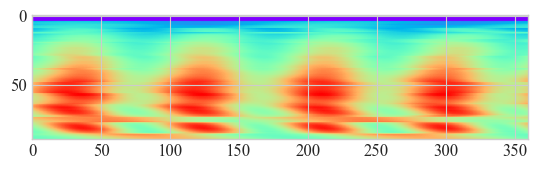

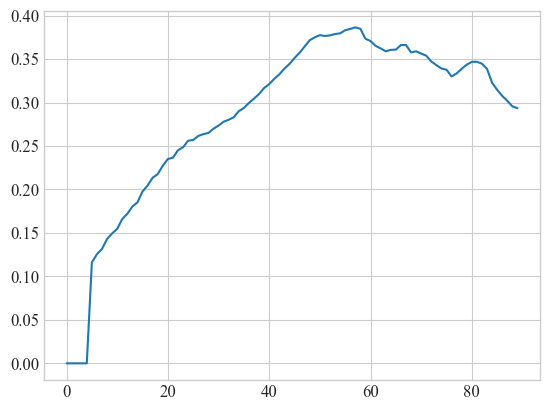

In [80]:
efficiency = np.array(efficiency)
plt.imshow(efficiency,cmap = 'rainbow')
plt.show()
eff_ang = t_fit

W = np.mean(efficiency,axis = 1)
plt.plot(W)

In [81]:
carrier = np.zeros(len(lambda_c))
for j in range(len(lambda_c)):
    freqs = np.zeros(360)
    for a in range(360):
        data = calibration_mod[a]
        try:
            f,p = LombFreq(j, data)
            freqs[a]= f
        except:
            freqs[a] = np.nan
    carrier[j] = np.median(freqs)

In [82]:
def LombModel(a,j,thresh,W):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
    freq = carrier[j]
    Wq= W[j,a]
    Wu= W[j,a]

    x = wavnums[start:stop] #select mod period
    data = calibration_mod[a] 
    y = data[start:stop]
    dy = data_err
 

    ls = LombScargle(x, y)
    frequency, power = ls.autopower(minimum_frequency=carrier[j]-.002,maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    best_frequency = frequency[np.argmax(power)]
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,u,q] = ls.model_parameters(freq)
        U = -u/Wu
        Q = q/Wq
        dolp = (((U)**2 +(Q)**2)**0.5)
        aolp = 0.5*np.arctan2(U,Q)
        if dolp > 1:
            [prob,U,Q] =[np.NAN,np.NAN,np.NAN]
            
    else:
        [prob,U,Q,dolp,aolp] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp,aolp,Q,U,prob,offset])

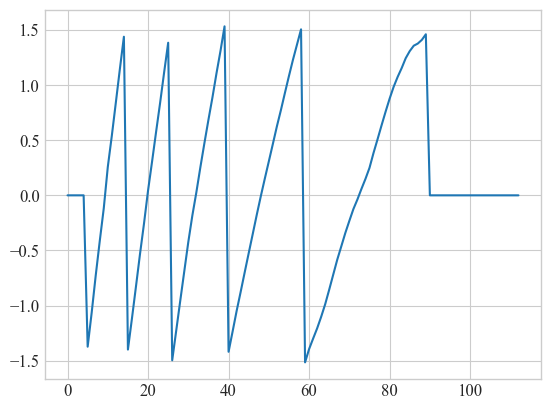

In [83]:
offset = []
results = np.zeros([len(lambda_c),360,6])
for j in range(len(lambda_c)):
    
    for a in range(0,360):
        try:
            results[j,a] = LombModel(a,j,1,efficiency)  
        except:
            w =1  
            
phase = results[:,0,1]
plt.plot(phase)

In [84]:
aolp_cal = np.zeros([len(angles)])
dolp_cal = np.zeros([len(angles)])
dolp_error = np.zeros([len(angles)])
error1 = np.zeros([len(angles)])

j = 74
for a in range(360):
    try:
        out = LombModel(a,j,.1,efficiency)  
        aolp_cal[a] = np.rad2deg(out[1] - phase[j])
        dolp_cal[a] = out[0]
        dolp_error[a] = (out[0] - 1)
        error1[a] = angles[a] - aolp_cal[a]
    except:
        pass


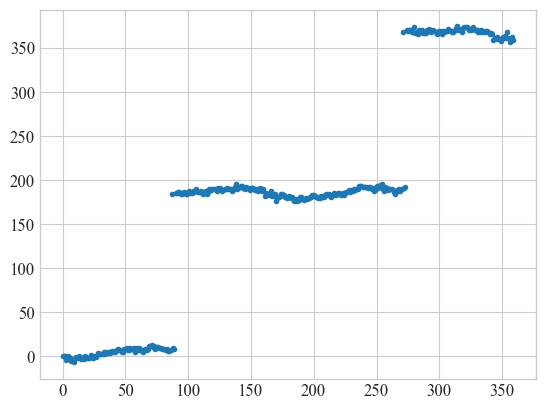

In [85]:
plt.plot(angles,error1,'.')

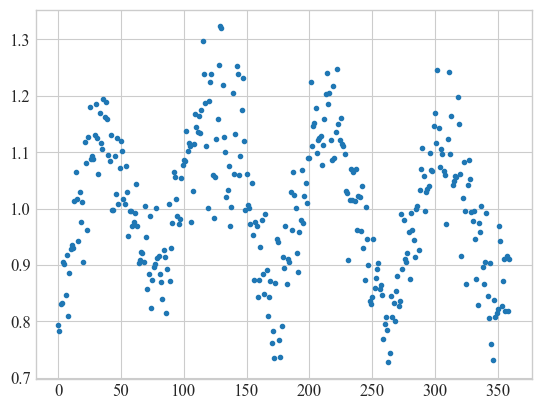

In [86]:
plt.plot(angles,dolp_cal,'.')

In [297]:
LUT = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Calibration//8.1.2022//LUT_compare//'

In [298]:
t = '23C//'

In [299]:
temps = np.arange(20, 150,5)
numtemps = len(temps)
imgs1 = np.zeros([numtemps,256,320])
imgs2 = np.zeros([numtemps,256,320])
std1 = np.zeros([numtemps,256,320])
std2 = np.zeros([numtemps,256,320])
t1 = np.zeros(numtemps)
t2 = np.zeros(numtemps)

In [300]:
len(temps)

26

In [301]:
for i in range(numtemps):
    with h5py.File(LUT + str(t) + str(round(temps[i],3))+'C.h5', "r") as f:

            imgs1[i] = np.mean(np.array(f[list(f.keys())[0]]),axis = 0)
            imgs2[i] = np.mean(np.array(f[list(f.keys())[1]]),axis = 0)
            std1[i] = np.array(f[list(f.keys())[2]])
            std2[i] = np.array(f[list(f.keys())[3]])
            t1[i] = np.array(f[list(f.keys())[4]])
            t2[i] = np.array(f[list(f.keys())[5]])


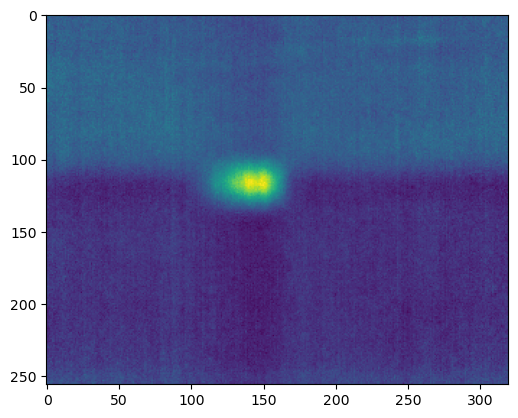

In [302]:
plt.style.use('default')
plt.imshow(imgs1[-1])

In [303]:
im1 = []
im2 = []
for t in range(numtemps):
    
    c1 = (imgs1[t] - np.mean(imgs1[t][160:170,145:155]))    
    c2 = (imgs2[t] - np.mean(imgs2[t][190:225,0:50]))    
    
    
    im1.append(c1)
    im2.append(c2)

In [304]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

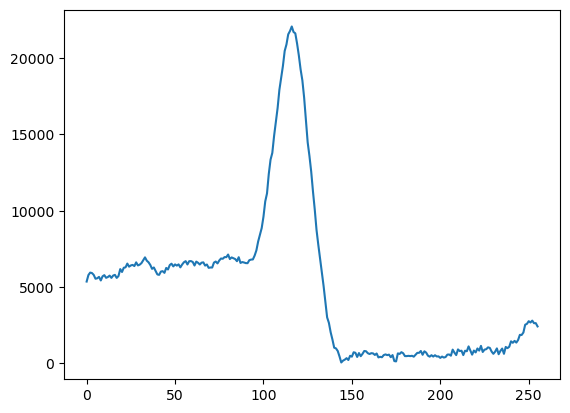

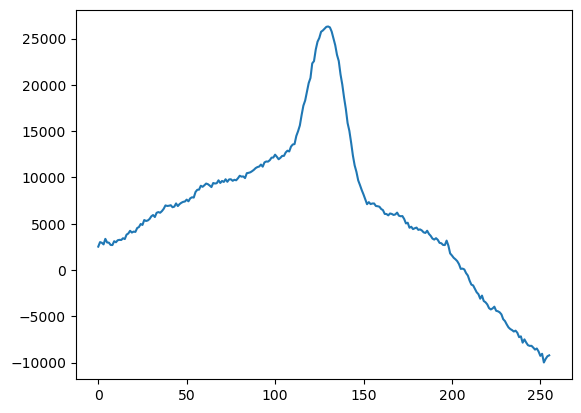

In [305]:
p1 = pixel_registration(im1[-1],cal_file1,waves,0,320)
p2 = pixel_registration(im2[-1],cal_file2,waves,0,320)
plt.plot(np.sum(p1,axis = 1))
plt.show()
plt.plot(np.sum(p2,axis = 1))
plt.show()
y2 = np.argmax(np.sum(p2,axis = 1))
y1 = np.argmax(np.sum(p1,axis = 1))
#y2 = 131
#y1 = 118

In [306]:
responses = np.zeros([len(temps),len(waves)])
responses1 = np.zeros([len(temps),len(waves)])
responses2 = np.zeros([len(temps),len(waves)])
responses_err = np.zeros([len(temps),len(waves)])
responses_err1 = np.zeros([len(temps),len(waves)])
responses_err2 = np.zeros([len(temps),len(waves)])

for t in range(len(temps)):
    p2 = pixel_registration(im2[t],cal_file2,waves,ymin2,ymax2)
    p1 = pixel_registration(im1[t],cal_file1,waves,ymin1,ymax1)
    s2 = pixel_registration(std2[t],cal_file2,waves,ymin2,ymax2)
    s1 = pixel_registration(std1[t],cal_file1,waves,ymin1,ymax1)

    err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
    responses[t]= (p1[y1-ymin1]+p2[y2-ymin2])
    responses_err[t]= err
    
    responses1[t]= p1[y1-ymin1]
    responses_err1[t]= s1[y1-ymin1]
    responses2[t]= p2[y2-ymin2]
    responses_err2[t]= s2[y2-ymin2]

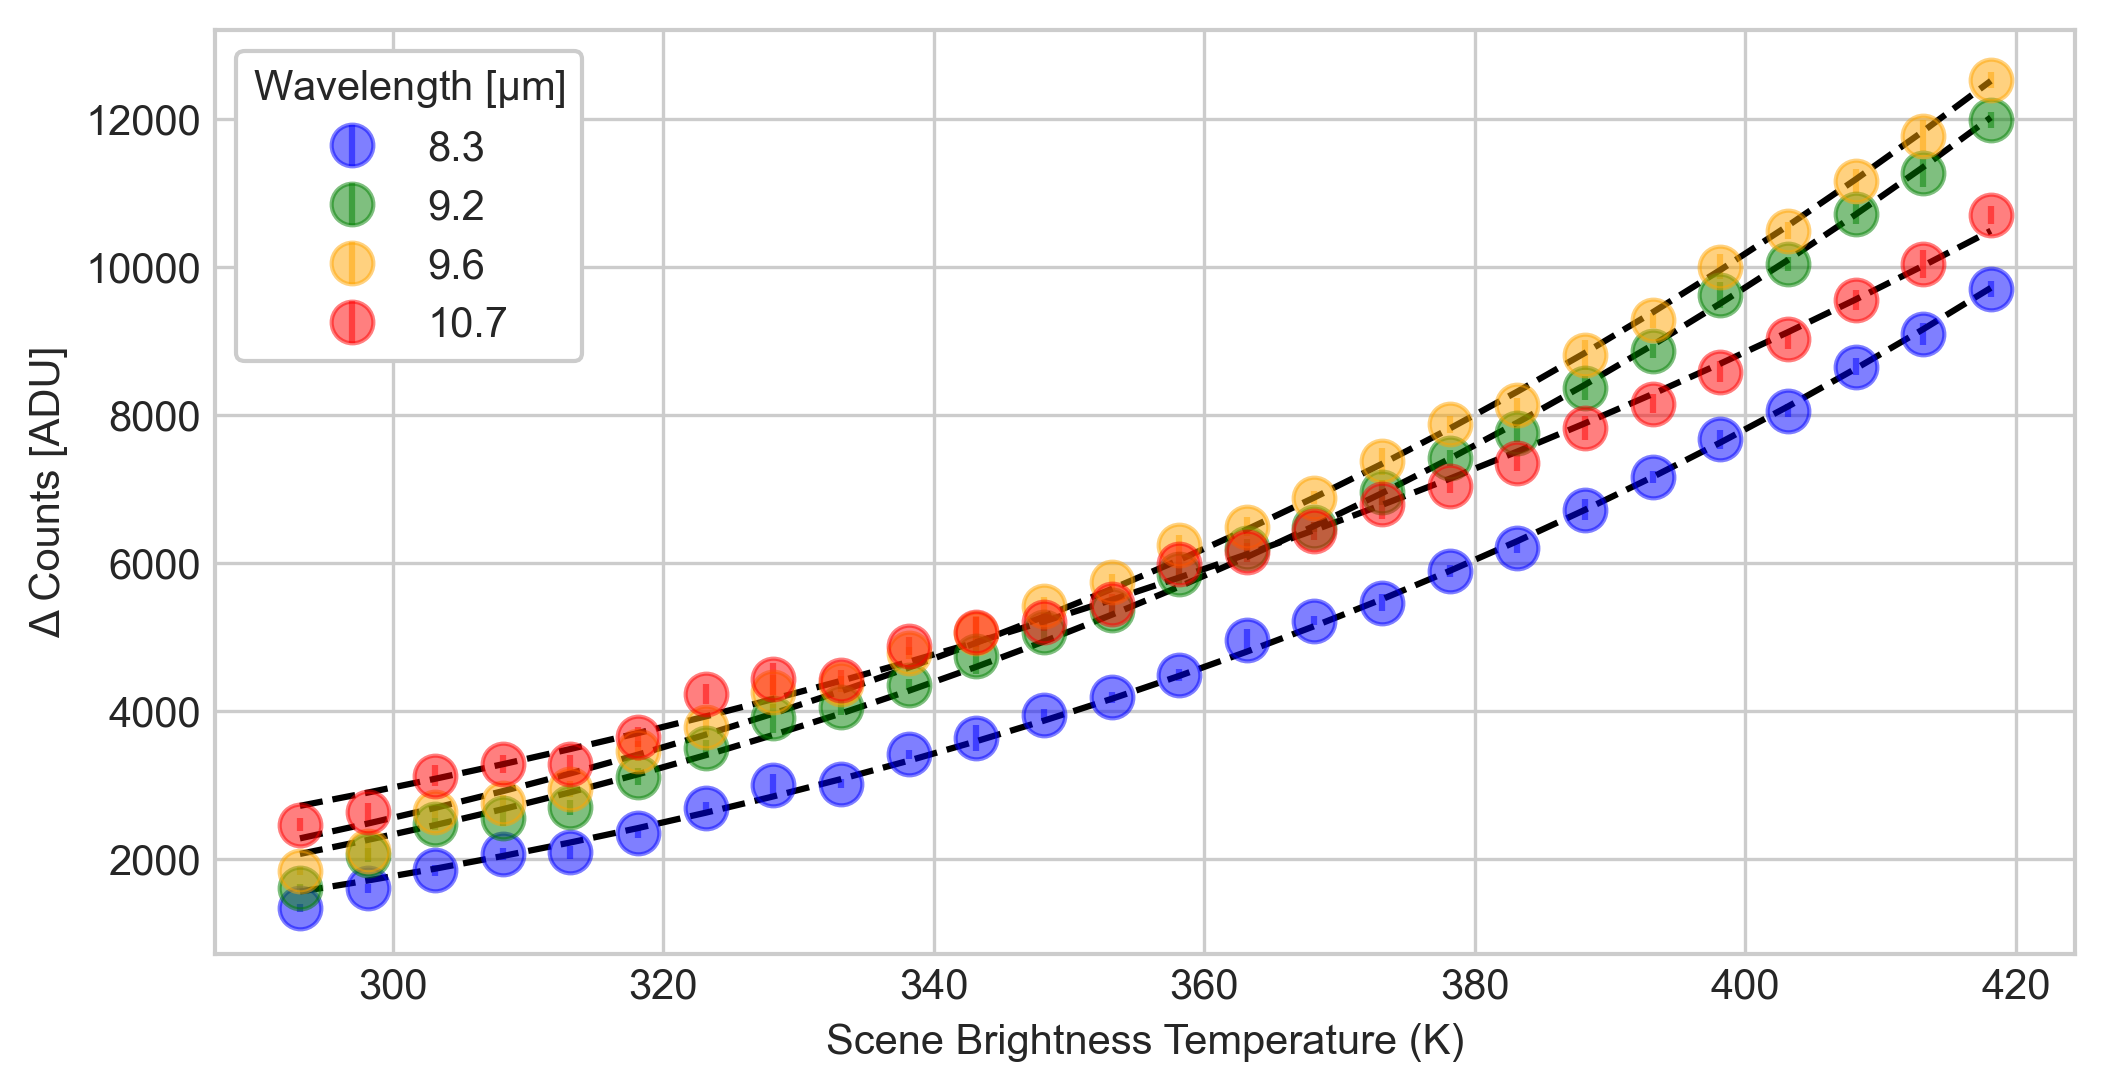

In [307]:
plt.style.use('seaborn-whitegrid')

""" Fitting Function"""
def func(x, a, b):
    y = a*(x-b)**4 
    return y

colors = ['blue','green','orange','red']
#temps = np.arange(40, 150,5)
fig = plt.subplots(figsize = [8,4])
plt.gcf().set_dpi(300)

nu = [24,46,54,80]
for i in range(4):
    
    ind = nu[i]
    start = pixel1[ind]
    stop  = pixel2[ind]

    x = temps + 273.15
    y = np.sum(responses[:,start:stop],axis = 1)
    y_err = np.sum(responses_err[:,start:stop],axis = 1)
    x2 = np.arange(30,60) + 273.15 #needs to be in kelvin

    popt, pcov = curve_fit(func, x, y)
    
    plt.plot(x, func(x, *popt), 'k--')

    plt.errorbar(x,y,yerr = y_err,fmt='.',color = colors[i],alpha=0.5,markersize = 20,label = str(np.round(lambda_c[ind],1)))

plt.xlabel("Scene Brightness Temperature (K)")
plt.ylabel("\u0394 Counts [ADU]")
legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()


In [308]:
var = np.zeros([95,2])
covar = np.zeros([95,2])

for ind in range(95):
    start = pixel1[ind]
    stop  = pixel2[ind]
    
    x = temps + 273.15
    y = np.sum(responses[:,start:stop],axis = 1)
    y_err = np.sum(responses_err[:,start:stop],axis = 1)

    popt, pcov = curve_fit(func, x, y, sigma = y_err)

    var[ind] = popt
    covar[ind] = np.sqrt(np.diag(pcov))

In [313]:
temp = np.linspace(-20,50,40) + 273.15
nedts = np.zeros([len(waves),len(temp)])
for i in range(95):
    for t in range(len(temp)):
        tem = temp[t]
        snr =  0
        delta = 0
        start = pixel1[i]
        stop  = pixel2[i]

        #e = np.mean(responses_err[:,start:stop])
        #e = np.sum(responses_err[:,start:stop]/responses[:,start:stop])
        e = np.sum(responses_err[:,start:stop]/responses[:,start:stop])/len(temps)

        
        while snr < e:
            snr = np.abs(func(tem+delta/2,var[i,0],var[i,1])-func(tem-delta/2,var[i,0],var[i,1]))
            delta = delta +.001 

        nedts[i,t] = delta

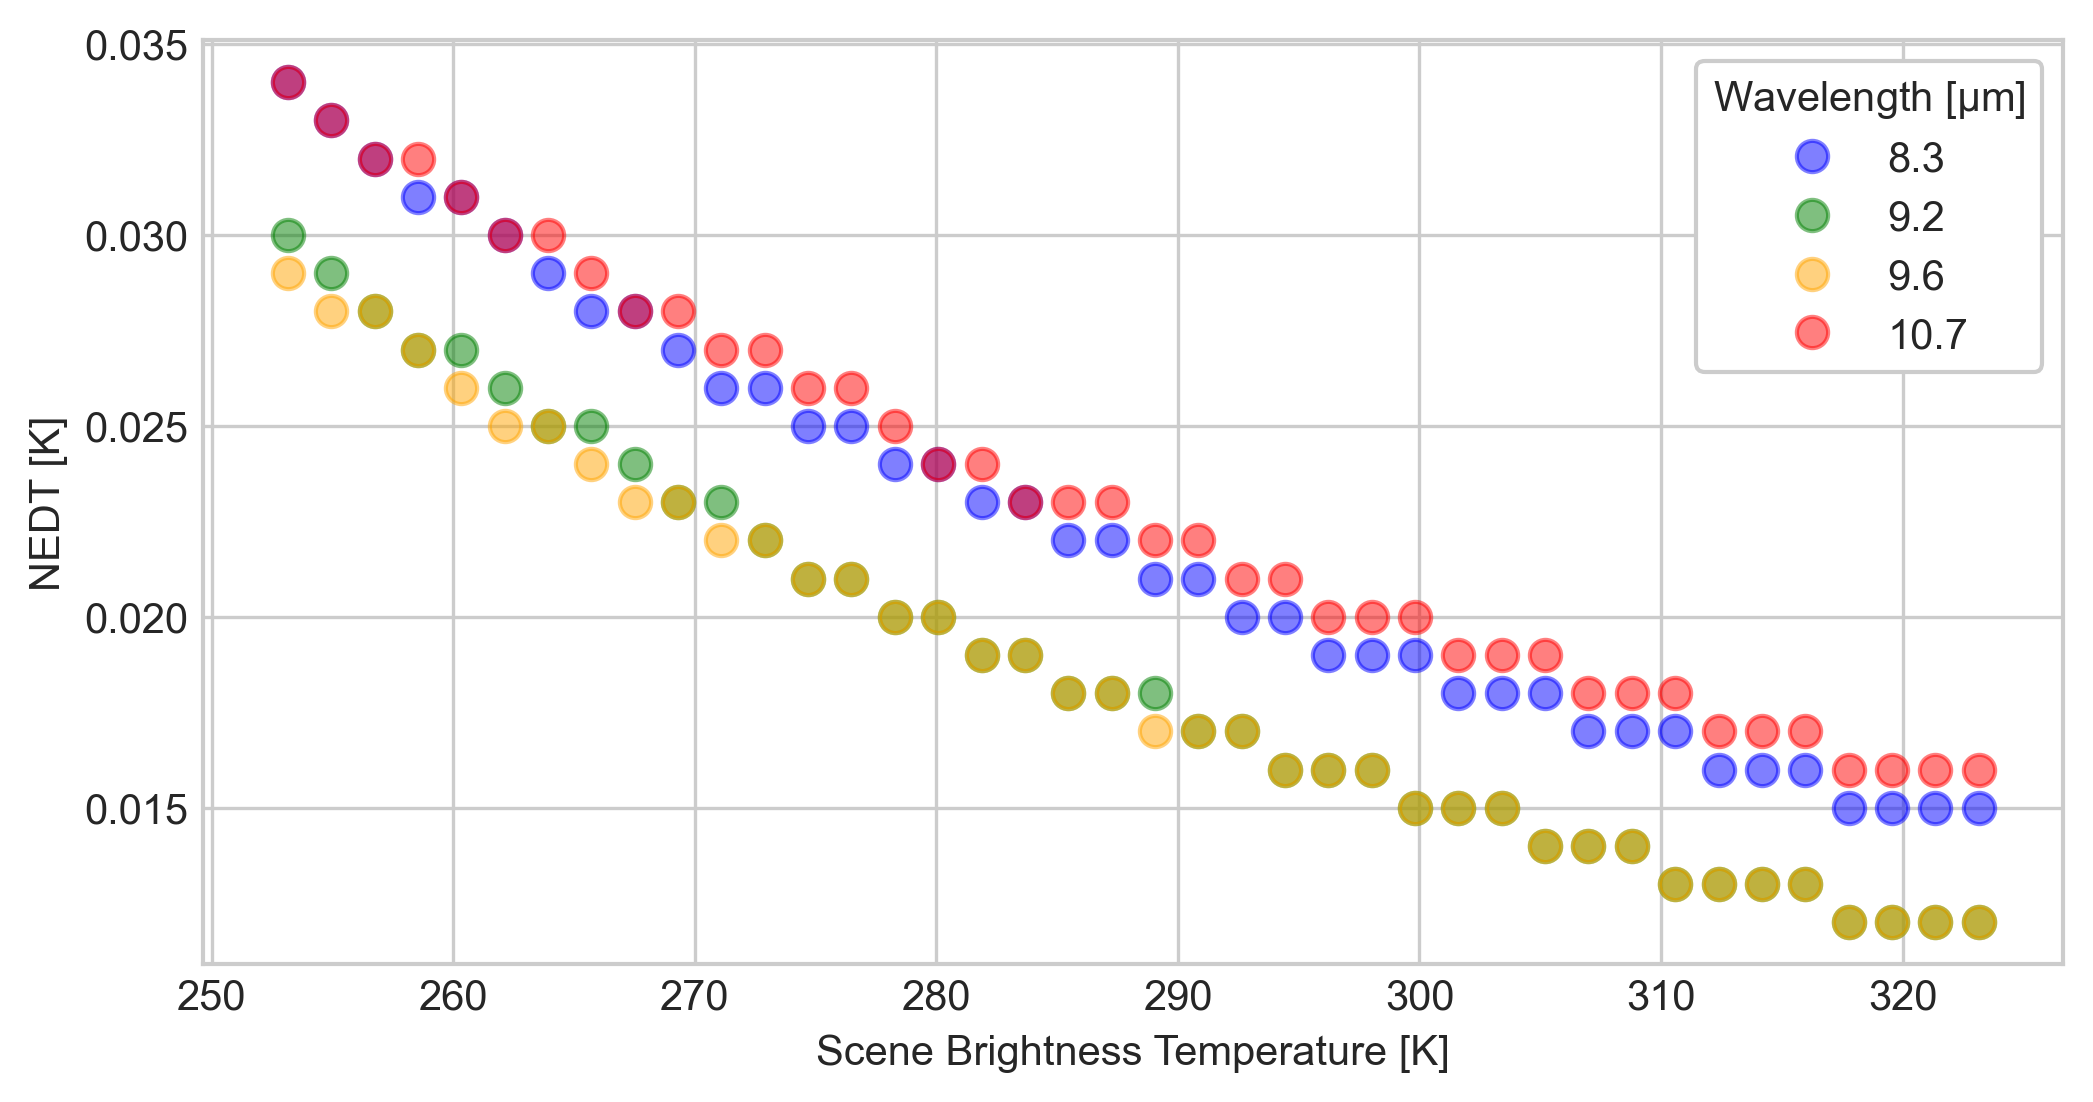

In [314]:
fig = plt.subplots(figsize = [8,4])
plt.gcf().set_dpi(300)
for i in range(4):
    ind = nu[i]
    plt.plot(temp,nedts[ind-10],'.',label = str(np.round(lambda_c[ind],1)), markersize = 15,color = colors[i],alpha = 0.5)
plt.legend( title='Wavelength [$\mathdefault{\mu}$m]')
plt.gcf().set_dpi(300)
plt.ylabel("NEDT [K]")
plt.xlabel("Scene Brightness Temperature [K]")

legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [472]:
hf = h5py.File('C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Calibration//8.1.2022//calibration.h5', 'w')
g = hf.create_group('pixel')
g.create_dataset('wavelength',data= lambda_c)
g.create_dataset('pixel1',data=pixel1)
g.create_dataset('pixel2',data=pixel2)

g = hf.create_group('transmission')
g.create_dataset('t_unpol',data= t_unpol)
g.create_dataset('t_pol', data=transmission_aolp)
g.create_dataset('angles',data=angles)

g = hf.create_group('polarization')
g.create_dataset('carrier',data= carrier)
g.create_dataset('W',data=efficiency)
g.create_dataset('W_ang',data=eff_ang)
g.create_dataset('phase',data=phase)
g.create_dataset('wavenums',data=wavnums)

g = hf.create_group('radiometric')
g.create_dataset('nedt',data= nedts)
g.create_dataset('var',data=var)
g.create_dataset('covar',data=covar)

hf.close()